In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [57]:
train_df = pd.read_csv("data/bean-leaf-leasions-classification/train.csv")
val_df = pd.read_csv("data/bean-leaf-leasions-classification/val.csv")

data_path = "data/bean-leaf-leasions-classification/"

train_df["image:FILE"] = train_df["image:FILE"].apply(lambda x: data_path + x)
val_df["image:FILE"] = val_df["image:FILE"].apply(lambda x: data_path + x)

train_df.head()

,image:FILE,category
0,data/bean-leaf-leasions-classification/train/h...,0
1,data/bean-leaf-leasions-classification/train/h...,0
2,data/bean-leaf-leasions-classification/train/h...,0
3,data/bean-leaf-leasions-classification/train/h...,0
4,data/bean-leaf-leasions-classification/train/h...,0


In [58]:
train_df.shape, val_df.shape

((1034, 2), (133, 2))

<Axes: xlabel='category'>

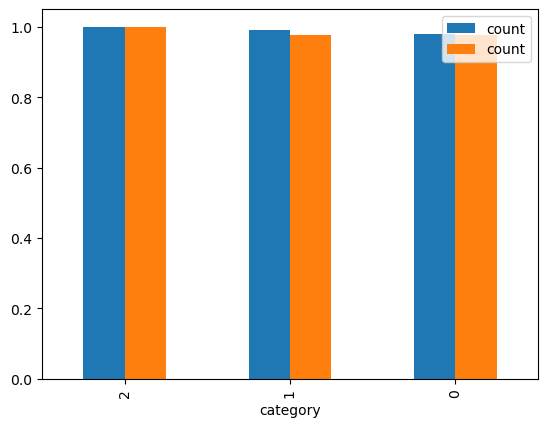

In [59]:
# Plot the distribution of labels in train and validation sets on the same plot
cat_counts = pd.concat([train_df.category.value_counts(), val_df.category.value_counts()], axis=1)

# Normalise cat_counts
# cat_counts -= cat_counts.mean()
# cat_counts /= cat_counts.std()

cat_counts /= cat_counts.max()

cat_counts.plot(kind='bar')

In [47]:
encoder = LabelEncoder()
encoder.fit(train_df.category.values)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float),
])

In [60]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(self.dataframe.category.values)).long().to(device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        image = Image.open(image_path).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

train_dataset = CustomImageDataset(train_df, transform)
val_dataset = CustomImageDataset(val_df, transform)

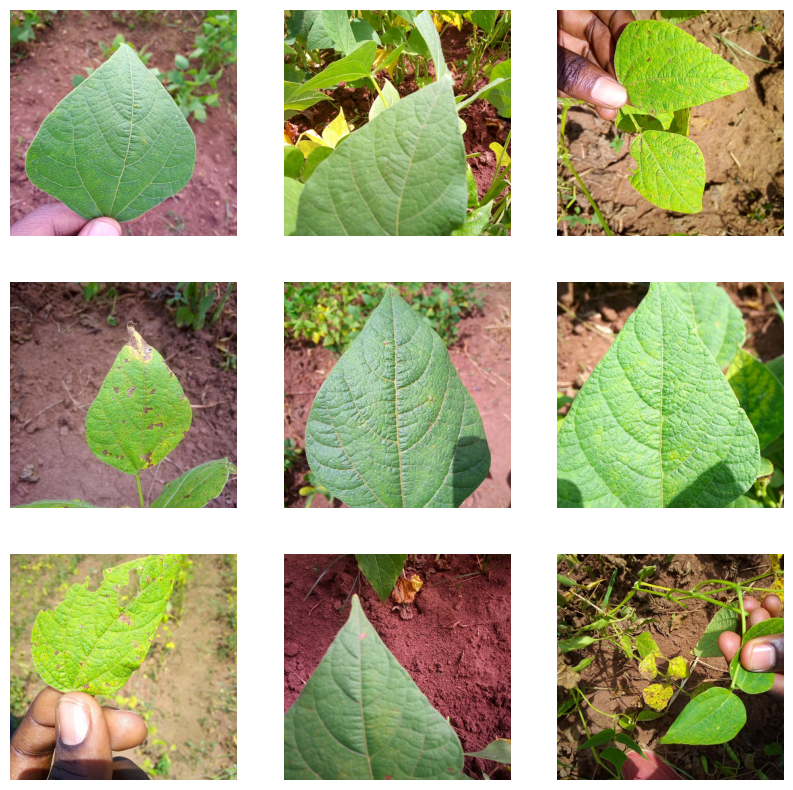

In [62]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        image = Image.open(train_df.sample(n=1).iloc[0, 0]).convert('RGB')
        ax[i, j].imshow(image)
        ax[i, j].axis("off")

plt.show()

In [64]:
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [65]:
model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\yashs/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:03<00:00, 13.5MB/s]


In [66]:
for param in model.parameters():
    param.requires_grad = True

model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [69]:
num_classes = train_df.category.nunique()

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [79]:
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


for epoch in range(EPOCHS):
    train_loss = val_loss = 0.0
    train_acc = val_acc = 0.0

    for images, labels in train_loader:
        outputs = model(images)

        loss = criterion(outputs, labels)
        train_loss += loss.item()

        train_acc += (torch.argmax(outputs.data, dim=1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss_history.append(round(train_loss / 1000, 4))
    train_accuracy_history.append(round((train_acc / len(train_df)) * 100, 4))

    for images, labels in val_loader:
        outputs = model(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        val_acc += (torch.argmax(outputs.data, dim=1) == labels).sum().item()

    
    val_loss_history.append(round(val_loss / 1000, 4))
    val_accuracy_history.append(round((val_acc / len(val_df)) * 100, 4))

    print(f'\nEpoch {epoch+1} / {EPOCHS}')
    print(f'Train Loss: {train_loss_history[-1]:.4f}, Validation Loss: {val_loss_history[-1]:.4f}')
    print(f'Train Acc: {train_accuracy_history[-1]:.2f}%, Validation Acc: {val_accuracy_history[-1]:.2f}%')

print('Training complete!')


Epoch 1 / 20
Train Loss: 0.0174, Validation Loss: 0.0028
Train Acc: 96.62%, Validation Acc: 95.49%

Epoch 2 / 20
Train Loss: 0.0176, Validation Loss: 0.0031
Train Acc: 97.29%, Validation Acc: 91.73%

Epoch 3 / 20
Train Loss: 0.0127, Validation Loss: 0.0034
Train Acc: 96.33%, Validation Acc: 94.74%

Epoch 4 / 20
Train Loss: 0.0035, Validation Loss: 0.0016
Train Acc: 99.13%, Validation Acc: 97.74%

Epoch 5 / 20
Train Loss: 0.0093, Validation Loss: 0.0033
Train Acc: 97.00%, Validation Acc: 94.74%

Epoch 6 / 20
Train Loss: 0.0235, Validation Loss: 0.0086
Train Acc: 94.39%, Validation Acc: 89.47%

Epoch 7 / 20
Train Loss: 0.0186, Validation Loss: 0.0056
Train Acc: 96.33%, Validation Acc: 92.48%

Epoch 8 / 20
Train Loss: 0.0105, Validation Loss: 0.0031
Train Acc: 97.87%, Validation Acc: 95.49%

Epoch 9 / 20
Train Loss: 0.0036, Validation Loss: 0.0020
Train Acc: 99.03%, Validation Acc: 96.24%

Epoch 10 / 20
Train Loss: 0.0093, Validation Loss: 0.0023
Train Acc: 97.97%, Validation Acc: 94.74%

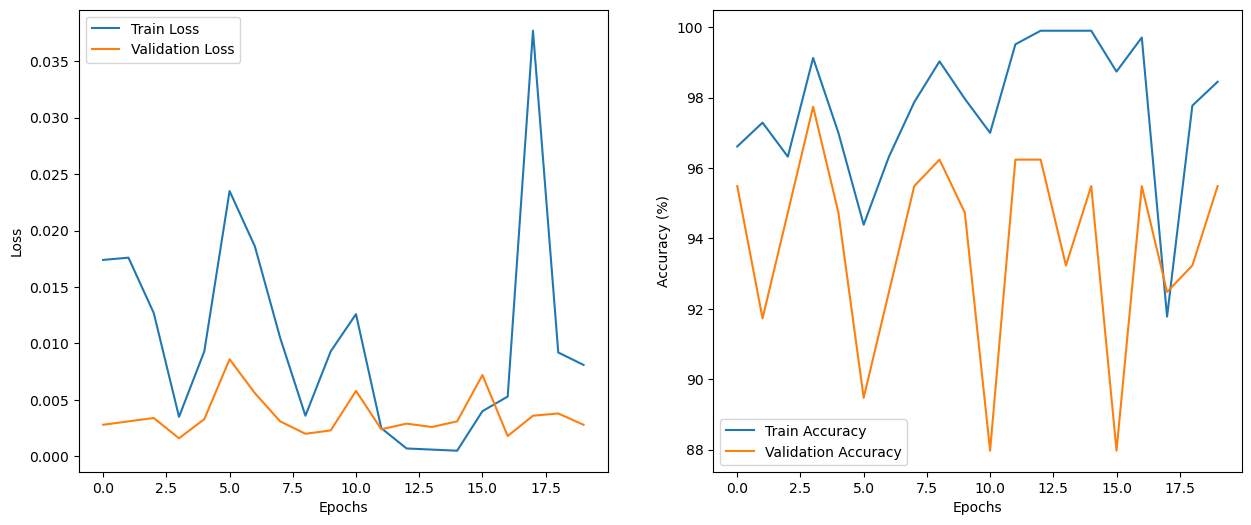

In [80]:
# Subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(train_loss_history, label='Train Loss')
ax1.plot(val_loss_history, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy_history, label='Train Accuracy')
ax2.plot(val_accuracy_history, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()


## Transfer Learning

In [81]:
pre_model = models.googlenet(weights='DEFAULT')

# Freeze all layers except the last one
for param in pre_model.parameters():
    param.requires_grad = False

num_classes = train_df.category.nunique()
pre_model.fc = nn.Linear(pre_model.fc.in_features, num_classes)
pre_model.fc.requires_grad = True

pre_model.to(device)

pre_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [82]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = Adam(pre_model.parameters(), lr=0.001)

pre_train_loss_history = []
pre_val_loss_history = []
pre_train_accuracy_history = []
pre_val_accuracy_history = []


for epoch in range(EPOCHS):
    train_loss = val_loss = 0.0
    train_acc = val_acc = 0.0

    for images, labels in train_loader:
        outputs = pre_model(images)

        loss = criterion(outputs, labels)
        train_loss += loss.item()

        train_acc += (torch.argmax(outputs.data, dim=1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pre_train_loss_history.append(round(train_loss / 1000, 4))
    pre_train_accuracy_history.append(round((train_acc / len(train_df)) * 100, 4))

    for images, labels in val_loader:
        outputs = pre_model(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        val_acc += (torch.argmax(outputs.data, dim=1) == labels).sum().item()

    
    pre_val_loss_history.append(round(val_loss / 1000, 4))
    pre_val_accuracy_history.append(round((val_acc / len(val_df)) * 100, 4))

    print(f'\nEpoch {epoch+1} / {EPOCHS}')
    print(f'Train Loss: {pre_train_loss_history[-1]:.4f}, Validation Loss: {pre_val_loss_history[-1]:.4f}')
    print(f'Train Acc: {pre_train_accuracy_history[-1]:.2f}%, Validation Acc: {pre_val_accuracy_history[-1]:.2f}%')

print('Training complete!')


Epoch 1 / 10
Train Loss: 0.1141, Validation Loss: 0.0134
Train Acc: 60.06%, Validation Acc: 61.65%

Epoch 2 / 10
Train Loss: 0.0871, Validation Loss: 0.0106
Train Acc: 71.47%, Validation Acc: 69.92%

Epoch 3 / 10
Train Loss: 0.0806, Validation Loss: 0.0111
Train Acc: 72.73%, Validation Acc: 71.43%

Epoch 4 / 10
Train Loss: 0.0778, Validation Loss: 0.0105
Train Acc: 76.02%, Validation Acc: 73.68%

Epoch 5 / 10
Train Loss: 0.0691, Validation Loss: 0.0093
Train Acc: 78.14%, Validation Acc: 76.69%

Epoch 6 / 10
Train Loss: 0.0754, Validation Loss: 0.0099
Train Acc: 76.11%, Validation Acc: 78.20%

Epoch 7 / 10
Train Loss: 0.0688, Validation Loss: 0.0088
Train Acc: 78.43%, Validation Acc: 76.69%

Epoch 8 / 10
Train Loss: 0.0689, Validation Loss: 0.0104
Train Acc: 79.79%, Validation Acc: 72.18%

Epoch 9 / 10
Train Loss: 0.0717, Validation Loss: 0.0090
Train Acc: 79.11%, Validation Acc: 76.69%

Epoch 10 / 10
Train Loss: 0.0674, Validation Loss: 0.0087
Train Acc: 77.85%, Validation Acc: 77.44%

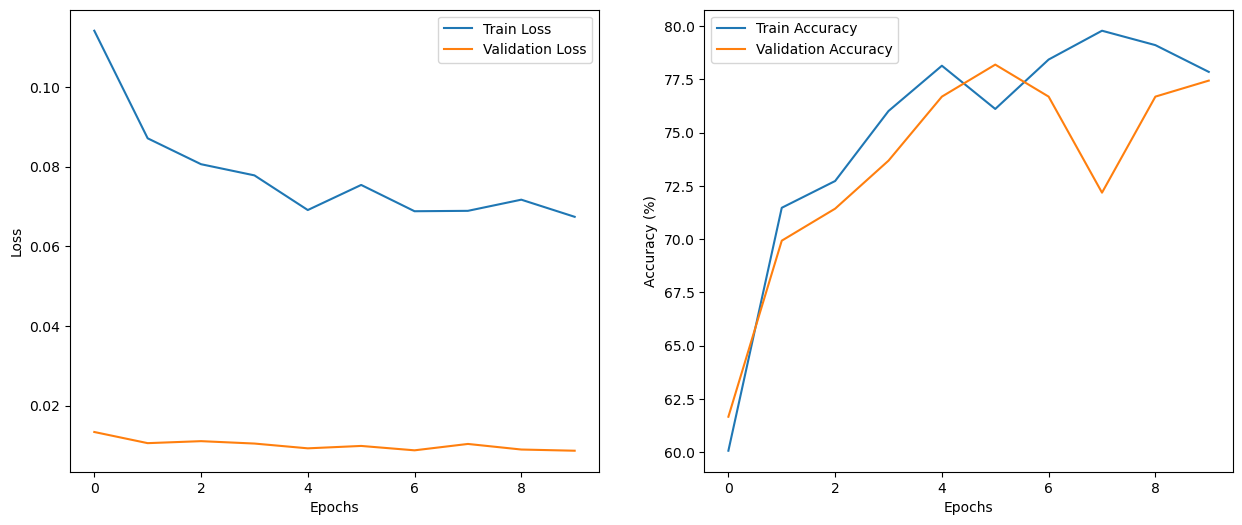

In [83]:
# Subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(pre_train_loss_history, label='Train Loss')
ax1.plot(pre_val_loss_history, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(pre_train_accuracy_history, label='Train Accuracy')
ax2.plot(pre_val_accuracy_history, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()